# C hyperparameter tuning with grid search on Logistic regression

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

In [42]:
%%time
## sample_500k is a sample from main dataset 
preprocess_data = pd.read_csv("preprocessed_3title_100k.csv")
preprocess_data.head(3)

Wall time: 6.5 s


,Unnamed: 0,question,code,tags,word_count_before,word_count_after,is_code
0,0,gvim window path issu gvim window path issu gv...,"['\\...\\gvim\\vim73\n', '\\...\\gvim\n', 'vim...",windows-7 windows-xp vim gvim,749,341,1
1,1,pass quotient via quotient map preserv topolog...,[],general-topology,701,446,0
2,2,jqueri cycl function paramet jqueri cycl funct...,"['$container.cycle(i, manualEffects[i]);', '$(...",jquery jquery-cycle,1083,211,1


In [3]:
def text_splitter(text):
    return text.split()

In [4]:
# binary='true' will give a binary vectorizer
tag_vectorizer = CountVectorizer(tokenizer = text_splitter, binary=True)
multi_label_y = tag_vectorizer.fit_transform(preprocess_data['tags'].values.astype(str))

In [5]:
# make sum column wise
tag_column_sum = multi_label_y.sum(axis=0).tolist()[0]

In [6]:
# To select n number of top tags
def select_top_tags(n):
    
    # To get sotred list (means: tags appear in maximum number of questions come first)
    # top 10: [3711, 15246, 22934, 15324, 1054, 15713, 3720, 24481, 14905, 1897]
    sorted_tags = sorted(range(len(tag_column_sum)), key=lambda i: tag_column_sum[i], reverse=True)
    
    # With this line of code we get tags in our columns which are come in most of the questions
    # we will get shape: (999999, n)
    multi_label_n_y = multi_label_y[:,sorted_tags[:n]]
    return multi_label_n_y
# 
def questions_covered_fn(n):
    multi_label_n_y = select_top_tags(n)
    
    # This line will give us row wise sum of each row  [[1, 2],           [[3],
    #                                                   [4, 3]]     to     [7]]
    row_sum_array = multi_label_n_y.sum(axis=1)

    # Counts the number of non-zero values in the array
    return (np.count_nonzero(row_sum_array==0))
# With this code we checking how much percent questions are explained by how many tags
# Here we are starting from 500 because we think top 500 are most important tags we can't skip them
questions_covered=[]
total_tags=multi_label_y.shape[1]
total_qs=preprocess_data.shape[0]
for i in range(500, total_tags, 100):
    questions_covered.append(np.round(((total_qs-questions_covered_fn(i))/total_qs)*100,3))

In [7]:
multi_label_n_y = select_top_tags(500)
print("number of questions that are not covered :", questions_covered_fn(5500),"out of ", total_qs)

number of questions that are not covered : 896 out of  100000


In [8]:
print("Number of tags in sample :", multi_label_y.shape[1])
print("number of tags taken :", multi_label_n_y.shape[1],"-->",round((multi_label_n_y.shape[1]/multi_label_y.shape[1]),3)*100,"%")

Number of tags in sample : 18646
number of tags taken : 500 --> 2.7 %


In [9]:
total_size=preprocess_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocess_data.head(train_size)
x_test=preprocess_data.tail(total_size - train_size)

y_train = multi_label_n_y[0:train_size,:]
y_test = multi_label_n_y[train_size:total_size,:]

In [10]:
%%time
# To get new features with tfidf technique get 200000 features with upto 3-grams
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", tokenizer = text_splitter, sublinear_tf=False, ngram_range=(1,3))
# Apply this vectorizer only on question data column
x_train_multi_label = vectorizer.fit_transform(x_train['question'])
x_test_multi_label = vectorizer.transform(x_test['question'])

Wall time: 57.3 s


In [11]:
# Now check data shapes after featurization
print("Dimensions of train data X:",x_train_multi_label.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multi_label.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 91388) Y : (80000, 500)
Dimensions of test data X: (20000, 91388) Y: (20000, 500)


In [13]:
param_grid = [    
    {
    'estimator__C' : [0.001,0.01,0.1,1,10,20]
    }
]

In [14]:
logModel = OneVsRestClassifier(LogisticRegression())

In [15]:
classifier = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [16]:
import time
start = time.time()
classifier.fit(x_train_multi_label, y_train)
print("Time it takes to run this :",(time.time()-start)/60,"minutes")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 131.4min finished


Time it takes to run this : 163.06704697211583 minutes


In [20]:
classifier.best_estimator_

OneVsRestClassifier(estimator=LogisticRegression(C=20))

In [41]:
scores = pd.DataFrame({
"split0" : list(classifier.cv_results_['split0_test_score']),
"split1":list(classifier.cv_results_['split1_test_score']),
"split2": list(classifier.cv_results_['split2_test_score']),
"means": list(classifier.cv_results_['mean_test_score']),
"stds": list(classifier.cv_results_['std_test_score']),
"rank": list(classifier.cv_results_['rank_test_score']),
"C's":[0.001,0.01,0.1,1,10,20]})
scores.to_csv("scores.csv")
scores

,split0,split1,split2,means,stds,rank,C's
0,0.099261,0.098286,0.098365,0.098637,0.000442,5,0.001
1,0.099261,0.098286,0.098365,0.098637,0.000442,5,0.010
2,0.123223,0.119999,0.121616,0.121613,0.001317,4,0.100
3,0.190235,0.189448,0.192492,0.190725,0.001290,3,1.000
4,0.223760,0.227585,0.228456,0.226600,0.002040,2,10.000
5,0.225372,0.229385,0.229018,0.227925,0.001811,1,20.000


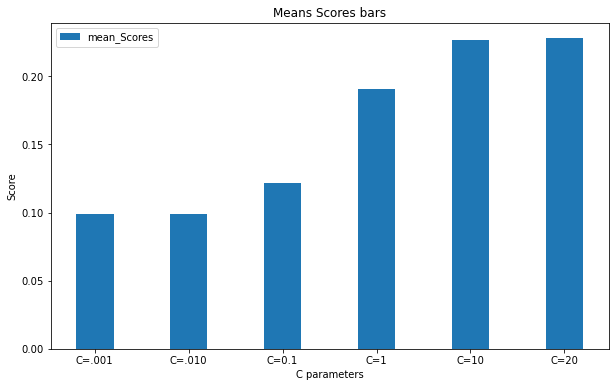

In [68]:
plt.figure(figsize=(10,6))
X = ['C=.001','C=.010',"C=0.1",'C=1','C=10','C=20']
X_axis = np.arange(len(X))
plt.bar(X_axis, list(scores["means"]), 0.4, label = 'mean_Scores')
  
plt.xticks(X_axis, X)
plt.xlabel("C parameters")
plt.ylabel("Score")
plt.title("Means Scores bars")
plt.legend()
plt.show()

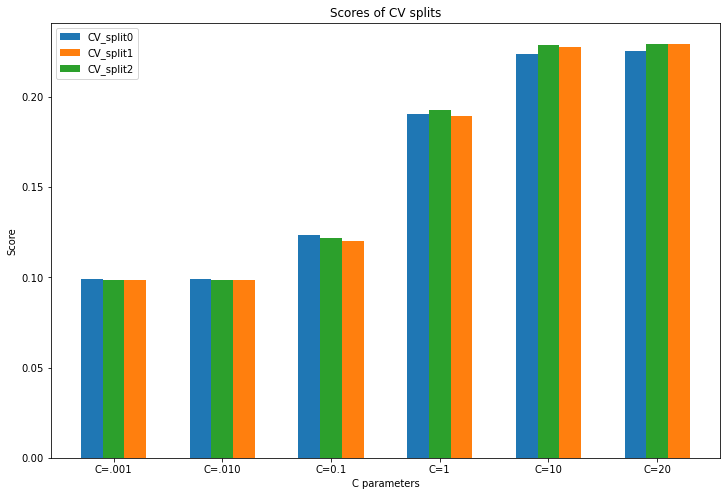

In [64]:
plt.figure(figsize=(12,8))
X = ['C=.001','C=.010',"C=0.1",'C=1','C=10','C=20']
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, list(scores["split0"]), 0.2, label = 'CV_split0')
plt.bar(X_axis + 0.2, list(scores["split1"]), 0.2, label = 'CV_split1')
plt.bar(X_axis, list(scores["split2"]), 0.2, label = 'CV_split2')
  
plt.xticks(X_axis, X)
plt.xlabel("C parameters")
plt.ylabel("Score")
plt.title("Scores of CV splits")
plt.legend()
plt.show()

In [27]:
classifier.cv_results_

{'mean_fit_time': array([ 729.66392271,  726.57284021,  921.38793596, 1613.13118283,
        3099.31731351, 2435.07060703]),
 'std_fit_time': array([  1.0381594 ,   9.49583441,  30.03210402,   2.28140558,
         36.41781134, 758.64347598]),
 'mean_score_time': array([7.83805625, 8.57874425, 8.76657224, 9.34037264, 9.9819955 ,
        4.31679575]),
 'std_score_time': array([0.02898435, 0.09492749, 0.44358582, 0.0935338 , 0.20549384,
        1.46007428]),
 'param_estimator__C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__C': 0.001},
  {'estimator__C': 0.01},
  {'estimator__C': 0.1},
  {'estimator__C': 1},
  {'estimator__C': 10},
  {'estimator__C': 20}],
 'split0_test_score': array([0.09926126, 0.09926126, 0.12322346, 0.19023512, 0.2237597 ,
        0.22537218]),
 'split1_test_score': array([0.09828627, 0.09828627, 0.1199985 , 0.18944763, 0.227

**Observations**
* From above parameter hypertuning on C or Lamda we can clearly see that c=10 and c=20 are performing better than others.
### Hence we dicide to go with C=20 because this one giving best results out of all other c's